Textarea(value='', description='API Key:', layout=Layout(width='50%'), placeholder='Enter your Alpha Vantage A…

Dropdown(description='Stock Symbol:', layout=Layout(width='50%'), options=('IBM', 'AAPL', 'GOOGL', 'TSLA'), va…

Text(value='5min', description='Timeframe:', layout=Layout(width='50%'))

FloatText(value=10000.0, description='Investment Amount:', layout=Layout(width='50%'))

FloatText(value=0.05, description='Stop Loss (%):', layout=Layout(width='50%'))

FloatText(value=0.1, description='Target (%):', layout=Layout(width='50%'))

IntText(value=9, description='Short-term SMA Periods:', layout=Layout(width='50%'))

IntText(value=10, description='Long-term SMA Periods:', layout=Layout(width='50%'))

Button(description='Run Strategy', style=ButtonStyle())

100%|██████████| 99/99 [00:00<00:00, 2879.32it/s]


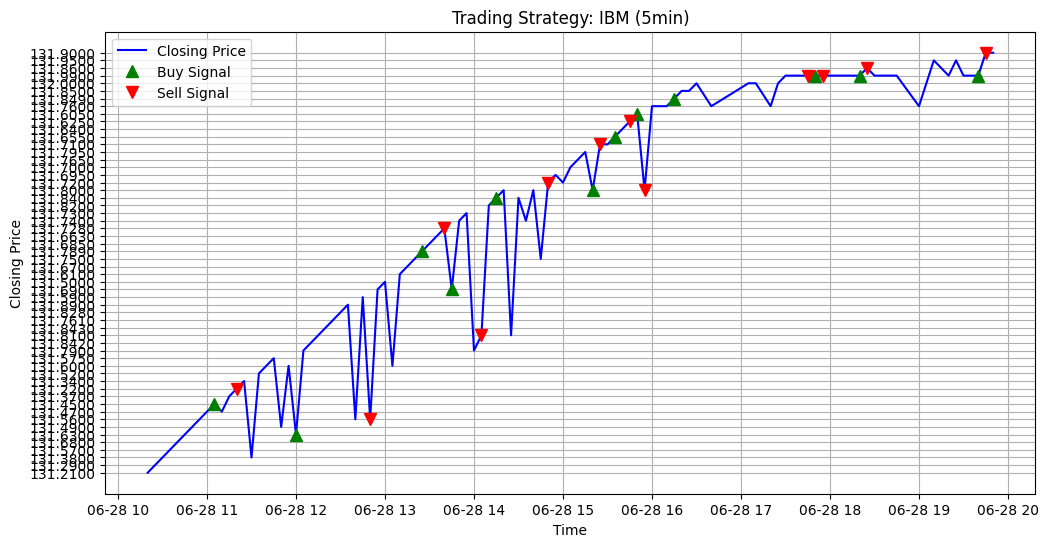

Total Buy Signals: 12
Total Sell Signals: 12
Accuracy: 100.00%
Total Profit/Loss: -276.97
Elapsed Time: 0.04 seconds


In [1]:
import time
import requests
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

# Define the timeframe (5 minutes)
timeframe = "5min"

# Define the variables for your trading strategy
investment = 10000  # Total investment amount
stop_loss_percentage = 0.05  # 10% stop loss
target_percentage = 0.1  # 20% target

# Define the hyperparameters for your trading strategy
short_term_sma_periods = 9
long_term_sma_periods = 10

# Define the API key widget
api_key_widget = widgets.Textarea(
    placeholder='Enter your Alpha Vantage API key',
    description='API Key:',
    layout=widgets.Layout(width='50%')
)
display(api_key_widget)

# Define the stock symbol widget
stock_symbol_widget = widgets.Dropdown(
    options=['IBM', 'AAPL', 'GOOGL', 'TSLA'],
    value='IBM',
    description='Stock Symbol:',
    layout=widgets.Layout(width='50%')
)
display(stock_symbol_widget)

# Define the timeframe widget
timeframe_widget = widgets.Text(
    value=timeframe,
    description='Timeframe:',
    layout=widgets.Layout(width='50%')
)
display(timeframe_widget)

# Define the variables for your trading strategy widgets
investment_widget = widgets.FloatText(
    value=investment,
    description='Investment Amount:',
    layout=widgets.Layout(width='50%')
)
display(investment_widget)

stop_loss_percentage_widget = widgets.FloatText(
    value=stop_loss_percentage,
    description='Stop Loss (%):',
    layout=widgets.Layout(width='50%')
)
display(stop_loss_percentage_widget)

target_percentage_widget = widgets.FloatText(
    value=target_percentage,
    description='Target (%):',
    layout=widgets.Layout(width='50%')
)
display(target_percentage_widget)

# Define the hyperparameters for your trading strategy widgets
short_term_sma_periods_widget = widgets.IntText(
    value=short_term_sma_periods,
    description='Short-term SMA Periods:',
    layout=widgets.Layout(width='50%')
)
display(short_term_sma_periods_widget)

long_term_sma_periods_widget = widgets.IntText(
    value=long_term_sma_periods,
    description='Long-term SMA Periods:',
    layout=widgets.Layout(width='50%')
)
display(long_term_sma_periods_widget)

# Define the button widget for running the strategy
run_button = widgets.Button(description="Run Strategy")
display(run_button)

# Function to run the strategy
def run_strategy(button):
    # Get the values from the widgets
    api_key = api_key_widget.value
    stock_symbol = stock_symbol_widget.value
    timeframe = timeframe_widget.value
    investment = investment_widget.value
    stop_loss_percentage = stop_loss_percentage_widget.value
    target_percentage = target_percentage_widget.value
    short_term_sma_periods = short_term_sma_periods_widget.value
    long_term_sma_periods = long_term_sma_periods_widget.value

    # Fetch data from the API
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock_symbol}&interval={timeframe}&apikey={api_key}&datatype=json"
    response = requests.get(url)
    data = response.json()

    # Extract the time series data from the API response
    time_series_data = data["Time Series ({})".format(timeframe)]

    # Convert the time series data to a pandas DataFrame for easier manipulation
    import pandas as pd
    stock_data = pd.DataFrame.from_dict(time_series_data, orient="index")
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.sort_index(ascending=True, inplace=True)

    # Initialize lists for visualization
    buy_signals = []
    sell_signals = []
    accuracy = 0
    total_profit = 0

    # Estimate total iterations and initialize progress bar
    total_iterations = len(stock_data) - 1
    pbar = tqdm(total=total_iterations)

    # Implement your trading strategy
    start_time = time.time()

    current_position = None  # Variable to keep track of the current position

    for i in range(1, len(stock_data)):
        current_price = float(stock_data["4. close"][i])
        previous_price = float(stock_data["4. close"][i - 1])

        # Calculate the short-term SMA (5 periods)
        sma_short_term = stock_data["4. close"].rolling(window=short_term_sma_periods).mean()[i]

        # Calculate the long-term SMA (20 periods)
        sma_long_term = stock_data["4. close"].rolling(window=long_term_sma_periods).mean()[i]

        # Calculate the stop loss and target
        stop_loss = current_price - (current_price * stop_loss_percentage)
        target = current_price + (current_price * target_percentage)

        # Check for buy signal (short-term SMA crosses above long-term SMA)
        if current_position is None and sma_short_term > sma_long_term:
            buy_signals.append(i)
            current_position = "long"
            investment_amount = investment / current_price

        # Check for sell signal (short-term SMA crosses below long-term SMA or stop loss/target is hit)
        elif current_position == "long" and (sma_short_term < sma_long_term or current_price < stop_loss or current_price > target):
            sell_signals.append(i)
            current_position = None
            profit_loss_amount = investment_amount * (current_price - float(stock_data["4. close"][buy_signals[-1]]))
            total_profit += profit_loss_amount

        # Update the progress bar
        pbar.update(1)

    pbar.close()
    elapsed_time = time.time() - start_time

    # Calculate the accuracy of the strategy
    accuracy = (len(sell_signals) / len(buy_signals)) * 100 if buy_signals else 0

    # Visualize the trading strategy
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data["4. close"], label="Closing Price", color="blue")
    plt.plot(stock_data.iloc[buy_signals].index, stock_data["4. close"].iloc[buy_signals], "g^", markersize=8, label="Buy Signal")
    plt.plot(stock_data.iloc[sell_signals].index, stock_data["4. close"].iloc[sell_signals], "rv", markersize=8, label="Sell Signal")
    plt.xlabel("Time")
    plt.ylabel("Closing Price")
    plt.title("Trading Strategy: {} ({})".format(stock_symbol, timeframe))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the results
    print("Total Buy Signals: {}".format(len(buy_signals)))
    print("Total Sell Signals: {}".format(len(sell_signals)))
    print("Accuracy: {:.2f}%".format(accuracy))
    print("Total Profit/Loss: {:.2f}".format(total_profit))
    print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

# Assign the function to the button click event
run_button.on_click(run_strategy)
